In [1]:
from Main_modules.PnL_utilities import _calculate_weighted_cluster_returns_functional, _fit_var_and_forecast_functional, calculate_pnl_torch, _define_clusters_and_centroids_functional
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.func as func
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# --- REFACTORED Main processing function for a single window ---
def single_window_iteration_processor_refactored(
    lookback_asset_returns_item,
    eval_asset_returns_item_padded,
    current_eval_len_for_window,
    window_idx_batch,
    initial_n_clusters_config_static,
    cluster_method_static,
    var_order_static,
    sigma_for_weights_static,
    max_eval_len_static,
    run_naive_var_comparison_static,
    num_assets_overall_static,
    device_static
):
    actual_eval_asset_returns_item = eval_asset_returns_item_padded

    cluster_defs, cluster_names_ord, actual_n_clust_formed, _ = _define_clusters_and_centroids_functional(
        lookback_asset_returns_item, initial_n_clusters_config_static, cluster_method_static, device_static
    )

    # Removed 'if cluster_names_ord:'
    lookback_cluster_returns = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=lookback_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    # print(lookback_cluster_returns)

    # Removed 'if lookback_cluster_returns.numel() > 0 and lookback_cluster_returns.shape[1] > 0:'
    forecasted_cluster_returns_raw = _fit_var_and_forecast_functional(
        lookback_cluster_returns, actual_n_clust_formed, var_order_static,
        current_eval_len_for_window, device_static
    )


    # Removed 'if current_eval_len_for_window > 0:'
    true_eval_cluster_returns_raw = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=actual_eval_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    pnl_c_tensor = calculate_pnl_torch(forecasted_cluster_returns_raw, true_eval_cluster_returns_raw)
    # Removed 'if pnl_c_tensor.numel() > 0:'
    pnl_c_val = pnl_c_tensor.mean().to(torch.float32)
    # Removed 'if torch.isnan(pnl_c_val):'

    pnl_n_val = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    forecasted_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    true_eval_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)

    if run_naive_var_comparison_static:
        # Removed 'if lookback_asset_returns_item.numel() > 0 and lookback_asset_returns_item.shape[1] > 0 :'
        forecasted_naive_returns_raw = _fit_var_and_forecast_functional(
            lookback_asset_returns_item, num_assets_overall_static, var_order_static,
            current_eval_len_for_window, device_static
        )

        # Removed 'if current_eval_len_for_window > 0:'
        true_eval_naive_returns_raw = actual_eval_asset_returns_item

        pnl_n_tensor = calculate_pnl_torch(forecasted_naive_returns_raw, forecasted_naive_returns_raw)
        # Removed 'if pnl_n_tensor.numel() > 0:'
        pnl_n_val = pnl_n_tensor.mean().to(torch.float32)
        # Removed 'if torch.isnan(pnl_n_val):'

    return (pnl_c_val, forecasted_cluster_returns_raw, true_eval_cluster_returns_raw,
            pnl_n_val, forecasted_naive_returns_raw, true_eval_naive_returns_raw,
            window_idx_batch
           )

# --- REFACTORED Main sliding window function ---
def run_sliding_window_var_evaluation_vmap(
    asset_returns_tensor, initial_lookback_len, eval_len, n_clusters_config,
    cluster_method, var_order, sigma_intra_cluster, num_windows,
    device=None, store_sample_forecasts=True, run_naive_var_comparison=True
):
    # Removed 'if device is None:' device will be asset_returns_tensor.device if not passed
    effective_device = device if device is not None else asset_returns_tensor.device

    num_assets_overall = asset_returns_tensor.shape[1]
    tensor_total_len = asset_returns_tensor.shape[0]

    base_lookback_start_indices = torch.arange(num_windows, device=effective_device) * eval_len
    base_lookback_end_indices = base_lookback_start_indices + initial_lookback_len

    valid_mask_initial = (base_lookback_end_indices <= tensor_total_len) & \
                         (base_lookback_end_indices < tensor_total_len)

    filtered_lb_start_indices = base_lookback_start_indices[valid_mask_initial]
    filtered_lb_end_indices = base_lookback_end_indices[valid_mask_initial]
    original_window_indices_filtered = torch.arange(num_windows, device=effective_device)[valid_mask_initial]

    # Removed 'if len(filtered_lb_start_indices) == 0:' and early return

    num_potentially_valid_windows = len(filtered_lb_start_indices)
    current_eval_lens_for_filtered = torch.full((num_potentially_valid_windows,), eval_len, dtype=torch.long, device=effective_device)
    for i in range(num_potentially_valid_windows): # This loop might be empty if num_potentially_valid_windows is 0
        max_possible_eval_len = tensor_total_len - filtered_lb_end_indices[i]
        current_eval_lens_for_filtered[i] = min(eval_len, max_possible_eval_len)

    valid_mask_eval_len = current_eval_lens_for_filtered > 0

    final_lookback_start_indices = filtered_lb_start_indices[valid_mask_eval_len]
    final_lookback_end_indices = filtered_lb_end_indices[valid_mask_eval_len]
    final_current_eval_lens = current_eval_lens_for_filtered[valid_mask_eval_len]
    final_original_window_indices_batch = original_window_indices_filtered[valid_mask_eval_len]

    # Removed 'if len(final_lookback_start_indices) == 0:' and early return

    actual_num_windows_to_process = len(final_lookback_start_indices)

    batched_lookback_slices = []
    batched_eval_slices_padded = []

    # for _ in repeat_for_robustness:
    #   for p in lag_orders_to_test:
    #       for k in num_clusters_to_test:
    for s in range(actual_num_windows_to_process): # This loop might be empty
        start = final_lookback_start_indices[s]
        end = final_lookback_end_indices[s]

        lb_slice = asset_returns_tensor[start:end, :]
        batched_lookback_slices.append(lb_slice)

        eval_s = end
        current_L = final_current_eval_lens[s].item()
        eval_e = eval_s + current_L
        ev_slice_actual = asset_returns_tensor[eval_s:eval_e, :]

        # # Padding logic kept for vmap compatibility
        # if current_L < eval_len:
        #     padding = torch.zeros((eval_len - current_L, num_assets_overall),
        #                           dtype=asset_returns_tensor.dtype, device=effective_device)
        #     ev_slice_padded = torch.cat([ev_slice_actual, padding], dim=0)
        # elif current_L == eval_len:
        #     ev_slice_padded = ev_slice_actual
        # else:
        #     ev_slice_padded = ev_slice_actual[:eval_len,:]

        batched_eval_slices_padded.append(ev_slice_actual)

    # These stacks will error if their respective lists are empty (e.g., actual_num_windows_to_process is 0)
    final_batched_lookback_data = torch.stack(batched_lookback_slices)
    final_batched_eval_data_padded = torch.stack(batched_eval_slices_padded)


    vmapped_processor = func.vmap(
        single_window_iteration_processor_refactored,
        in_dims=(0, 0, None, 0,
                   None, None, None, None, None, None, None, None),
        out_dims=0, randomness='different'
    )

    all_pnl_c_vals, all_forecast_c, all_actual_c, \
    all_pnl_n_vals, all_forecast_n, all_actual_n, \
    processed_window_indices = vmapped_processor(
        final_batched_lookback_data,
        final_batched_eval_data_padded,
        eval_len,
        final_original_window_indices_batch,
        n_clusters_config,
        cluster_method,
        var_order,
        sigma_intra_cluster,
        eval_len,
        run_naive_var_comparison,
        num_assets_overall,
        effective_device
    )

    all_window_pnl_cluster_dicts = []
    all_window_pnl_naive_dicts = []

    for i in range(actual_num_windows_to_process): # This loop might be empty
        win_id = processed_window_indices[i].item()

        # Removed filter 'if all_pnl_c_vals[i].item() != 0.0 or all_forecast_c[i].abs().sum() > 1e-9:'
        all_window_pnl_cluster_dicts.append({
             'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_c_vals[i].item(),
             'VAR_Order': var_order, 'Method': 'Clustered VAR'
         })

        if run_naive_var_comparison:
            # Removed filter for naive pnl/forecast values
            all_window_pnl_naive_dicts.append({
                'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_n_vals[i].item(),
                'VAR_Order': var_order, 'Method': 'Naive VAR'
            })

    sample_forecast_c, sample_actual_c, sample_win_idx = None, None, -1
    # Removed 'and actual_num_windows_to_process > 0' from condition
    if store_sample_forecasts:
        sample_idx_in_batch = 0 # Will error if actual_num_windows_to_process is 0
        actual_eval_len_for_sample = final_current_eval_lens[sample_idx_in_batch].item()

        sample_forecast_c = all_forecast_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_actual_c = all_actual_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_win_idx = processed_window_indices[sample_idx_in_batch].item()

    return {
        'cluster_avg_pnl_list': all_window_pnl_cluster_dicts,
        'naive_avg_pnl_list': all_window_pnl_naive_dicts,
        'sample_forecast_cluster': sample_forecast_c,
        'sample_actual_cluster': sample_actual_c,
        'sample_window_idx_cluster': sample_win_idx,
        'var_order_for_sample': var_order
    }


In [3]:
# --- REFACTORED Main processing function for a single window ---
def single_window_iteration_processor_refactored(
    lookback_asset_returns_item,
    eval_asset_returns_item_padded,
    current_eval_len_for_window,
    window_idx_batch,
    initial_n_clusters_config_static,
    cluster_method_static,
    var_order_static,
    sigma_for_weights_static,
    max_eval_len_static,
    run_naive_var_comparison_static,
    num_assets_overall_static,
    device_static
):
    actual_eval_asset_returns_item = eval_asset_returns_item_padded

    cluster_defs, cluster_names_ord, actual_n_clust_formed, _ = _define_clusters_and_centroids_functional(
        lookback_asset_returns_item, initial_n_clusters_config_static, cluster_method_static, device_static
    )

    # Removed 'if cluster_names_ord:'
    lookback_cluster_returns = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=lookback_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    # print(lookback_cluster_returns)

    # Removed 'if lookback_cluster_returns.numel() > 0 and lookback_cluster_returns.shape[1] > 0:'
    forecasted_cluster_returns_raw = _fit_var_and_forecast_functional(
        lookback_cluster_returns, actual_n_clust_formed, var_order_static,
        current_eval_len_for_window, device_static
    )


    # Removed 'if current_eval_len_for_window > 0:'
    true_eval_cluster_returns_raw = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=actual_eval_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    pnl_c_tensor = calculate_pnl_torch(forecasted_cluster_returns_raw, true_eval_cluster_returns_raw)
    # Removed 'if pnl_c_tensor.numel() > 0:'
    pnl_c_val = pnl_c_tensor.mean().to(torch.float32)
    # Removed 'if torch.isnan(pnl_c_val):'

    pnl_n_val = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    forecasted_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    true_eval_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)

    if run_naive_var_comparison_static:
        # Removed 'if lookback_asset_returns_item.numel() > 0 and lookback_asset_returns_item.shape[1] > 0 :'
        forecasted_naive_returns_raw = _fit_var_and_forecast_functional(
            lookback_asset_returns_item, num_assets_overall_static, var_order_static,
            current_eval_len_for_window, device_static
        )

        # Removed 'if current_eval_len_for_window > 0:'
        true_eval_naive_returns_raw = actual_eval_asset_returns_item

        pnl_n_tensor = calculate_pnl_torch(forecasted_naive_returns_raw, forecasted_naive_returns_raw)
        # Removed 'if pnl_n_tensor.numel() > 0:'
        pnl_n_val = pnl_n_tensor.mean().to(torch.float32)
        # Removed 'if torch.isnan(pnl_n_val):'

    return (pnl_c_val, forecasted_cluster_returns_raw, true_eval_cluster_returns_raw,
            pnl_n_val, forecasted_naive_returns_raw, true_eval_naive_returns_raw,
            window_idx_batch
           )

# --- REFACTORED Main sliding window function ---
def run_sliding_window_var_evaluation_vmap(
    asset_returns_tensor, initial_lookback_len, eval_len, n_clusters_config,
    cluster_method, var_order, sigma_intra_cluster, num_windows,
    device=None, store_sample_forecasts=True, run_naive_var_comparison=True
):
    # Removed 'if device is None:' device will be asset_returns_tensor.device if not passed
    effective_device = device if device is not None else asset_returns_tensor.device

    num_assets_overall = asset_returns_tensor.shape[1]
    tensor_total_len = asset_returns_tensor.shape[0]

    base_lookback_start_indices = torch.arange(num_windows, device=effective_device) * eval_len
    base_lookback_end_indices = base_lookback_start_indices + initial_lookback_len

    valid_mask_initial = (base_lookback_end_indices <= tensor_total_len) & \
                         (base_lookback_end_indices < tensor_total_len)

    filtered_lb_start_indices = base_lookback_start_indices[valid_mask_initial]
    filtered_lb_end_indices = base_lookback_end_indices[valid_mask_initial]
    original_window_indices_filtered = torch.arange(num_windows, device=effective_device)[valid_mask_initial]

    # Removed 'if len(filtered_lb_start_indices) == 0:' and early return

    num_potentially_valid_windows = len(filtered_lb_start_indices)
    current_eval_lens_for_filtered = torch.full((num_potentially_valid_windows,), eval_len, dtype=torch.long, device=effective_device)
    for i in range(num_potentially_valid_windows): # This loop might be empty if num_potentially_valid_windows is 0
        max_possible_eval_len = tensor_total_len - filtered_lb_end_indices[i]
        current_eval_lens_for_filtered[i] = min(eval_len, max_possible_eval_len)

    valid_mask_eval_len = current_eval_lens_for_filtered > 0

    final_lookback_start_indices = filtered_lb_start_indices[valid_mask_eval_len]
    final_lookback_end_indices = filtered_lb_end_indices[valid_mask_eval_len]
    final_current_eval_lens = current_eval_lens_for_filtered[valid_mask_eval_len]
    final_original_window_indices_batch = original_window_indices_filtered[valid_mask_eval_len]

    # Removed 'if len(final_lookback_start_indices) == 0:' and early return

    actual_num_windows_to_process = len(final_lookback_start_indices)

    batched_lookback_slices = []
    batched_eval_slices_padded = []

    # for _ in repeat_for_robustness:
    #   for p in lag_orders_to_test:
    #       for k in num_clusters_to_test:
    for s in range(actual_num_windows_to_process): # This loop might be empty
        start = final_lookback_start_indices[s]
        end = final_lookback_end_indices[s]

        lb_slice = asset_returns_tensor[start:end, :]
        batched_lookback_slices.append(lb_slice)

        eval_s = end
        current_L = final_current_eval_lens[s].item()
        eval_e = eval_s + current_L
        ev_slice_actual = asset_returns_tensor[eval_s:eval_e, :]

        # # Padding logic kept for vmap compatibility
        # if current_L < eval_len:
        #     padding = torch.zeros((eval_len - current_L, num_assets_overall),
        #                           dtype=asset_returns_tensor.dtype, device=effective_device)
        #     ev_slice_padded = torch.cat([ev_slice_actual, padding], dim=0)
        # elif current_L == eval_len:
        #     ev_slice_padded = ev_slice_actual
        # else:
        #     ev_slice_padded = ev_slice_actual[:eval_len,:]

        batched_eval_slices_padded.append(ev_slice_actual)

    # These stacks will error if their respective lists are empty (e.g., actual_num_windows_to_process is 0)
    final_batched_lookback_data = torch.stack(batched_lookback_slices)
    final_batched_eval_data_padded = torch.stack(batched_eval_slices_padded)


    vmapped_processor = func.vmap(
        single_window_iteration_processor_refactored,
        in_dims=(0, 0, None, 0,
                   None, None, None, None, None, None, None, None),
        out_dims=0, randomness='different'
    )

    all_pnl_c_vals, all_forecast_c, all_actual_c, \
    all_pnl_n_vals, all_forecast_n, all_actual_n, \
    processed_window_indices = vmapped_processor(
        final_batched_lookback_data,
        final_batched_eval_data_padded,
        eval_len,
        final_original_window_indices_batch,
        n_clusters_config,
        cluster_method,
        var_order,
        sigma_intra_cluster,
        eval_len,
        run_naive_var_comparison,
        num_assets_overall,
        effective_device
    )

    all_window_pnl_cluster_dicts = []
    all_window_pnl_naive_dicts = []

    for i in range(actual_num_windows_to_process): # This loop might be empty
        win_id = processed_window_indices[i].item()

        # Removed filter 'if all_pnl_c_vals[i].item() != 0.0 or all_forecast_c[i].abs().sum() > 1e-9:'
        all_window_pnl_cluster_dicts.append({
             'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_c_vals[i].item(),
             'VAR_Order': var_order, 'Method': 'Clustered VAR'
         })

        if run_naive_var_comparison:
            # Removed filter for naive pnl/forecast values
            all_window_pnl_naive_dicts.append({
                'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_n_vals[i].item(),
                'VAR_Order': var_order, 'Method': 'Naive VAR'
            })

    sample_forecast_c, sample_actual_c, sample_win_idx = None, None, -1
    # Removed 'and actual_num_windows_to_process > 0' from condition
    if store_sample_forecasts:
        sample_idx_in_batch = 0 # Will error if actual_num_windows_to_process is 0
        actual_eval_len_for_sample = final_current_eval_lens[sample_idx_in_batch].item()

        sample_forecast_c = all_forecast_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_actual_c = all_actual_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_win_idx = processed_window_indices[sample_idx_in_batch].item()

    return {
        'cluster_avg_pnl_list': all_window_pnl_cluster_dicts,
        'naive_avg_pnl_list': all_window_pnl_naive_dicts,
        'sample_forecast_cluster': sample_forecast_c,
        'sample_actual_cluster': sample_actual_c,
        'sample_window_idx_cluster': sample_win_idx,
        'var_order_for_sample': var_order
    }


In [4]:
# --- REFACTORED Main processing function for a single window ---
def single_window_iteration_processor_refactored(
    lookback_asset_returns_item,
    eval_asset_returns_item_padded,
    current_eval_len_for_window,
    window_idx_batch,
    initial_n_clusters_config_static,
    cluster_method_static,
    var_order_static,
    sigma_for_weights_static,
    max_eval_len_static,
    run_naive_var_comparison_static,
    num_assets_overall_static,
    device_static
):
    actual_eval_asset_returns_item = eval_asset_returns_item_padded

    cluster_defs, cluster_names_ord, actual_n_clust_formed, _ = _define_clusters_and_centroids_functional(
        lookback_asset_returns_item, initial_n_clusters_config_static, cluster_method_static, device_static
    )

    # Removed 'if cluster_names_ord:'
    lookback_cluster_returns = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=lookback_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    # print(lookback_cluster_returns)

    # Removed 'if lookback_cluster_returns.numel() > 0 and lookback_cluster_returns.shape[1] > 0:'
    forecasted_cluster_returns_raw = _fit_var_and_forecast_functional(
        lookback_cluster_returns, actual_n_clust_formed, var_order_static,
        current_eval_len_for_window, device_static
    )


    # Removed 'if current_eval_len_for_window > 0:'
    true_eval_cluster_returns_raw = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=actual_eval_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    pnl_c_tensor = calculate_pnl_torch(forecasted_cluster_returns_raw, true_eval_cluster_returns_raw)
    # Removed 'if pnl_c_tensor.numel() > 0:'
    pnl_c_val = pnl_c_tensor.mean().to(torch.float32)
    # Removed 'if torch.isnan(pnl_c_val):'

    pnl_n_val = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    forecasted_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    true_eval_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)

    if run_naive_var_comparison_static:
        # Removed 'if lookback_asset_returns_item.numel() > 0 and lookback_asset_returns_item.shape[1] > 0 :'
        forecasted_naive_returns_raw = _fit_var_and_forecast_functional(
            lookback_asset_returns_item, num_assets_overall_static, var_order_static,
            current_eval_len_for_window, device_static
        )

        # Removed 'if current_eval_len_for_window > 0:'
        true_eval_naive_returns_raw = actual_eval_asset_returns_item

        pnl_n_tensor = calculate_pnl_torch(forecasted_naive_returns_raw, forecasted_naive_returns_raw)
        # Removed 'if pnl_n_tensor.numel() > 0:'
        pnl_n_val = pnl_n_tensor.mean().to(torch.float32)
        # Removed 'if torch.isnan(pnl_n_val):'

    return (pnl_c_val, forecasted_cluster_returns_raw, true_eval_cluster_returns_raw,
            pnl_n_val, forecasted_naive_returns_raw, true_eval_naive_returns_raw,
            window_idx_batch
           )

# --- REFACTORED Main sliding window function ---
def run_sliding_window_var_evaluation_vmap(
    asset_returns_tensor, initial_lookback_len, eval_len, n_clusters_config,
    cluster_method, var_order, sigma_intra_cluster, num_windows,
    device=None, store_sample_forecasts=True, run_naive_var_comparison=True
):
    # Removed 'if device is None:' device will be asset_returns_tensor.device if not passed
    effective_device = device if device is not None else asset_returns_tensor.device

    num_assets_overall = asset_returns_tensor.shape[1]
    tensor_total_len = asset_returns_tensor.shape[0]

    base_lookback_start_indices = torch.arange(num_windows, device=effective_device) * eval_len
    base_lookback_end_indices = base_lookback_start_indices + initial_lookback_len

    valid_mask_initial = (base_lookback_end_indices <= tensor_total_len) & \
                         (base_lookback_end_indices < tensor_total_len)

    filtered_lb_start_indices = base_lookback_start_indices[valid_mask_initial]
    filtered_lb_end_indices = base_lookback_end_indices[valid_mask_initial]
    original_window_indices_filtered = torch.arange(num_windows, device=effective_device)[valid_mask_initial]

    # Removed 'if len(filtered_lb_start_indices) == 0:' and early return

    num_potentially_valid_windows = len(filtered_lb_start_indices)
    current_eval_lens_for_filtered = torch.full((num_potentially_valid_windows,), eval_len, dtype=torch.long, device=effective_device)
    for i in range(num_potentially_valid_windows): # This loop might be empty if num_potentially_valid_windows is 0
        max_possible_eval_len = tensor_total_len - filtered_lb_end_indices[i]
        current_eval_lens_for_filtered[i] = min(eval_len, max_possible_eval_len)

    valid_mask_eval_len = current_eval_lens_for_filtered > 0

    final_lookback_start_indices = filtered_lb_start_indices[valid_mask_eval_len]
    final_lookback_end_indices = filtered_lb_end_indices[valid_mask_eval_len]
    final_current_eval_lens = current_eval_lens_for_filtered[valid_mask_eval_len]
    final_original_window_indices_batch = original_window_indices_filtered[valid_mask_eval_len]

    # Removed 'if len(final_lookback_start_indices) == 0:' and early return

    actual_num_windows_to_process = len(final_lookback_start_indices)

    batched_lookback_slices = []
    batched_eval_slices_padded = []

    # for _ in repeat_for_robustness:
    #   for p in lag_orders_to_test:
    #       for k in num_clusters_to_test:
    for s in range(actual_num_windows_to_process): # This loop might be empty
        start = final_lookback_start_indices[s]
        end = final_lookback_end_indices[s]

        lb_slice = asset_returns_tensor[start:end, :]
        batched_lookback_slices.append(lb_slice)

        eval_s = end
        current_L = final_current_eval_lens[s].item()
        eval_e = eval_s + current_L
        ev_slice_actual = asset_returns_tensor[eval_s:eval_e, :]

        # # Padding logic kept for vmap compatibility
        # if current_L < eval_len:
        #     padding = torch.zeros((eval_len - current_L, num_assets_overall),
        #                           dtype=asset_returns_tensor.dtype, device=effective_device)
        #     ev_slice_padded = torch.cat([ev_slice_actual, padding], dim=0)
        # elif current_L == eval_len:
        #     ev_slice_padded = ev_slice_actual
        # else:
        #     ev_slice_padded = ev_slice_actual[:eval_len,:]

        batched_eval_slices_padded.append(ev_slice_actual)

    # These stacks will error if their respective lists are empty (e.g., actual_num_windows_to_process is 0)
    final_batched_lookback_data = torch.stack(batched_lookback_slices)
    final_batched_eval_data_padded = torch.stack(batched_eval_slices_padded)


    vmapped_processor = func.vmap(
        single_window_iteration_processor_refactored,
        in_dims=(0, 0, None, 0,
                   None, None, None, None, None, None, None, None),
        out_dims=0, randomness='different'
    )

    all_pnl_c_vals, all_forecast_c, all_actual_c, \
    all_pnl_n_vals, all_forecast_n, all_actual_n, \
    processed_window_indices = vmapped_processor(
        final_batched_lookback_data,
        final_batched_eval_data_padded,
        eval_len,
        final_original_window_indices_batch,
        n_clusters_config,
        cluster_method,
        var_order,
        sigma_intra_cluster,
        eval_len,
        run_naive_var_comparison,
        num_assets_overall,
        effective_device
    )

    all_window_pnl_cluster_dicts = []
    all_window_pnl_naive_dicts = []

    for i in range(actual_num_windows_to_process): # This loop might be empty
        win_id = processed_window_indices[i].item()

        # Removed filter 'if all_pnl_c_vals[i].item() != 0.0 or all_forecast_c[i].abs().sum() > 1e-9:'
        all_window_pnl_cluster_dicts.append({
             'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_c_vals[i].item(),
             'VAR_Order': var_order, 'Method': 'Clustered VAR'
         })

        if run_naive_var_comparison:
            # Removed filter for naive pnl/forecast values
            all_window_pnl_naive_dicts.append({
                'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_n_vals[i].item(),
                'VAR_Order': var_order, 'Method': 'Naive VAR'
            })

    sample_forecast_c, sample_actual_c, sample_win_idx = None, None, -1
    # Removed 'and actual_num_windows_to_process > 0' from condition
    if store_sample_forecasts:
        sample_idx_in_batch = 0 # Will error if actual_num_windows_to_process is 0
        actual_eval_len_for_sample = final_current_eval_lens[sample_idx_in_batch].item()

        sample_forecast_c = all_forecast_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_actual_c = all_actual_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_win_idx = processed_window_indices[sample_idx_in_batch].item()

    return {
        'cluster_avg_pnl_list': all_window_pnl_cluster_dicts,
        'naive_avg_pnl_list': all_window_pnl_naive_dicts,
        'sample_forecast_cluster': sample_forecast_c,
        'sample_actual_cluster': sample_actual_c,
        'sample_window_idx_cluster': sample_win_idx,
        'var_order_for_sample': var_order
    }


In [5]:
# --- REFACTORED Main processing function for a single window ---
def single_window_iteration_processor_refactored(
    lookback_asset_returns_item,
    eval_asset_returns_item_padded,
    current_eval_len_for_window,
    window_idx_batch,
    initial_n_clusters_config_static,
    cluster_method_static,
    var_order_static,
    sigma_for_weights_static,
    max_eval_len_static,
    run_naive_var_comparison_static,
    num_assets_overall_static,
    device_static
):
    actual_eval_asset_returns_item = eval_asset_returns_item_padded

    cluster_defs, cluster_names_ord, actual_n_clust_formed, _ = _define_clusters_and_centroids_functional(
        lookback_asset_returns_item, initial_n_clusters_config_static, cluster_method_static, device_static
    )

    # Removed 'if cluster_names_ord:'
    lookback_cluster_returns = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=lookback_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    # print(lookback_cluster_returns)

    # Removed 'if lookback_cluster_returns.numel() > 0 and lookback_cluster_returns.shape[1] > 0:'
    forecasted_cluster_returns_raw = _fit_var_and_forecast_functional(
        lookback_cluster_returns, actual_n_clust_formed, var_order_static,
        current_eval_len_for_window, device_static
    )


    # Removed 'if current_eval_len_for_window > 0:'
    true_eval_cluster_returns_raw = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=actual_eval_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    pnl_c_tensor = calculate_pnl_torch(forecasted_cluster_returns_raw, true_eval_cluster_returns_raw)
    # Removed 'if pnl_c_tensor.numel() > 0:'
    pnl_c_val = pnl_c_tensor.mean().to(torch.float32)
    # Removed 'if torch.isnan(pnl_c_val):'

    pnl_n_val = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    forecasted_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    true_eval_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)

    if run_naive_var_comparison_static:
        # Removed 'if lookback_asset_returns_item.numel() > 0 and lookback_asset_returns_item.shape[1] > 0 :'
        forecasted_naive_returns_raw = _fit_var_and_forecast_functional(
            lookback_asset_returns_item, num_assets_overall_static, var_order_static,
            current_eval_len_for_window, device_static
        )

        # Removed 'if current_eval_len_for_window > 0:'
        true_eval_naive_returns_raw = actual_eval_asset_returns_item

        pnl_n_tensor = calculate_pnl_torch(forecasted_naive_returns_raw, forecasted_naive_returns_raw)
        # Removed 'if pnl_n_tensor.numel() > 0:'
        pnl_n_val = pnl_n_tensor.mean().to(torch.float32)
        # Removed 'if torch.isnan(pnl_n_val):'

    return (pnl_c_val, forecasted_cluster_returns_raw, true_eval_cluster_returns_raw,
            pnl_n_val, forecasted_naive_returns_raw, true_eval_naive_returns_raw,
            window_idx_batch
           )

# --- REFACTORED Main sliding window function ---
def run_sliding_window_var_evaluation_vmap(
    asset_returns_tensor, initial_lookback_len, eval_len, n_clusters_config,
    cluster_method, var_order, sigma_intra_cluster, num_windows,
    device=None, store_sample_forecasts=True, run_naive_var_comparison=True
):
    # Removed 'if device is None:' device will be asset_returns_tensor.device if not passed
    effective_device = device if device is not None else asset_returns_tensor.device

    num_assets_overall = asset_returns_tensor.shape[1]
    tensor_total_len = asset_returns_tensor.shape[0]

    base_lookback_start_indices = torch.arange(num_windows, device=effective_device) * eval_len
    base_lookback_end_indices = base_lookback_start_indices + initial_lookback_len

    valid_mask_initial = (base_lookback_end_indices <= tensor_total_len) & \
                         (base_lookback_end_indices < tensor_total_len)

    filtered_lb_start_indices = base_lookback_start_indices[valid_mask_initial]
    filtered_lb_end_indices = base_lookback_end_indices[valid_mask_initial]
    original_window_indices_filtered = torch.arange(num_windows, device=effective_device)[valid_mask_initial]

    # Removed 'if len(filtered_lb_start_indices) == 0:' and early return

    num_potentially_valid_windows = len(filtered_lb_start_indices)
    current_eval_lens_for_filtered = torch.full((num_potentially_valid_windows,), eval_len, dtype=torch.long, device=effective_device)
    for i in range(num_potentially_valid_windows): # This loop might be empty if num_potentially_valid_windows is 0
        max_possible_eval_len = tensor_total_len - filtered_lb_end_indices[i]
        current_eval_lens_for_filtered[i] = min(eval_len, max_possible_eval_len)

    valid_mask_eval_len = current_eval_lens_for_filtered > 0

    final_lookback_start_indices = filtered_lb_start_indices[valid_mask_eval_len]
    final_lookback_end_indices = filtered_lb_end_indices[valid_mask_eval_len]
    final_current_eval_lens = current_eval_lens_for_filtered[valid_mask_eval_len]
    final_original_window_indices_batch = original_window_indices_filtered[valid_mask_eval_len]

    # Removed 'if len(final_lookback_start_indices) == 0:' and early return

    actual_num_windows_to_process = len(final_lookback_start_indices)

    batched_lookback_slices = []
    batched_eval_slices_padded = []

    # for _ in repeat_for_robustness:
    #   for p in lag_orders_to_test:
    #       for k in num_clusters_to_test:
    for s in range(actual_num_windows_to_process): # This loop might be empty
        start = final_lookback_start_indices[s]
        end = final_lookback_end_indices[s]

        lb_slice = asset_returns_tensor[start:end, :]
        batched_lookback_slices.append(lb_slice)

        eval_s = end
        current_L = final_current_eval_lens[s].item()
        eval_e = eval_s + current_L
        ev_slice_actual = asset_returns_tensor[eval_s:eval_e, :]

        # # Padding logic kept for vmap compatibility
        # if current_L < eval_len:
        #     padding = torch.zeros((eval_len - current_L, num_assets_overall),
        #                           dtype=asset_returns_tensor.dtype, device=effective_device)
        #     ev_slice_padded = torch.cat([ev_slice_actual, padding], dim=0)
        # elif current_L == eval_len:
        #     ev_slice_padded = ev_slice_actual
        # else:
        #     ev_slice_padded = ev_slice_actual[:eval_len,:]

        batched_eval_slices_padded.append(ev_slice_actual)

    # These stacks will error if their respective lists are empty (e.g., actual_num_windows_to_process is 0)
    final_batched_lookback_data = torch.stack(batched_lookback_slices)
    final_batched_eval_data_padded = torch.stack(batched_eval_slices_padded)


    vmapped_processor = func.vmap(
        single_window_iteration_processor_refactored,
        in_dims=(0, 0, None, 0,
                   None, None, None, None, None, None, None, None),
        out_dims=0, randomness='different'
    )

    all_pnl_c_vals, all_forecast_c, all_actual_c, \
    all_pnl_n_vals, all_forecast_n, all_actual_n, \
    processed_window_indices = vmapped_processor(
        final_batched_lookback_data,
        final_batched_eval_data_padded,
        eval_len,
        final_original_window_indices_batch,
        n_clusters_config,
        cluster_method,
        var_order,
        sigma_intra_cluster,
        eval_len,
        run_naive_var_comparison,
        num_assets_overall,
        effective_device
    )

    all_window_pnl_cluster_dicts = []
    all_window_pnl_naive_dicts = []

    for i in range(actual_num_windows_to_process): # This loop might be empty
        win_id = processed_window_indices[i].item()

        # Removed filter 'if all_pnl_c_vals[i].item() != 0.0 or all_forecast_c[i].abs().sum() > 1e-9:'
        all_window_pnl_cluster_dicts.append({
             'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_c_vals[i].item(),
             'VAR_Order': var_order, 'Method': 'Clustered VAR'
         })

        if run_naive_var_comparison:
            # Removed filter for naive pnl/forecast values
            all_window_pnl_naive_dicts.append({
                'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_n_vals[i].item(),
                'VAR_Order': var_order, 'Method': 'Naive VAR'
            })

    sample_forecast_c, sample_actual_c, sample_win_idx = None, None, -1
    # Removed 'and actual_num_windows_to_process > 0' from condition
    if store_sample_forecasts:
        sample_idx_in_batch = 0 # Will error if actual_num_windows_to_process is 0
        actual_eval_len_for_sample = final_current_eval_lens[sample_idx_in_batch].item()

        sample_forecast_c = all_forecast_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_actual_c = all_actual_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_win_idx = processed_window_indices[sample_idx_in_batch].item()

    return {
        'cluster_avg_pnl_list': all_window_pnl_cluster_dicts,
        'naive_avg_pnl_list': all_window_pnl_naive_dicts,
        'sample_forecast_cluster': sample_forecast_c,
        'sample_actual_cluster': sample_actual_c,
        'sample_window_idx_cluster': sample_win_idx,
        'var_order_for_sample': var_order
    }


In [6]:
# --- REFACTORED Main processing function for a single window ---
def single_window_iteration_processor_refactored(
    lookback_asset_returns_item,
    eval_asset_returns_item_padded,
    current_eval_len_for_window,
    window_idx_batch,
    initial_n_clusters_config_static,
    cluster_method_static,
    var_order_static,
    sigma_for_weights_static,
    max_eval_len_static,
    run_naive_var_comparison_static,
    num_assets_overall_static,
    device_static
):
    actual_eval_asset_returns_item = eval_asset_returns_item_padded

    cluster_defs, cluster_names_ord, actual_n_clust_formed, _ = _define_clusters_and_centroids_functional(
        lookback_asset_returns_item, initial_n_clusters_config_static, cluster_method_static, device_static
    )

    # Removed 'if cluster_names_ord:'
    lookback_cluster_returns = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=lookback_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    # print(lookback_cluster_returns)

    # Removed 'if lookback_cluster_returns.numel() > 0 and lookback_cluster_returns.shape[1] > 0:'
    forecasted_cluster_returns_raw = _fit_var_and_forecast_functional(
        lookback_cluster_returns, actual_n_clust_formed, var_order_static,
        current_eval_len_for_window, device_static
    )


    # Removed 'if current_eval_len_for_window > 0:'
    true_eval_cluster_returns_raw = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=actual_eval_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    pnl_c_tensor = calculate_pnl_torch(forecasted_cluster_returns_raw, true_eval_cluster_returns_raw)
    # Removed 'if pnl_c_tensor.numel() > 0:'
    pnl_c_val = pnl_c_tensor.mean().to(torch.float32)
    # Removed 'if torch.isnan(pnl_c_val):'

    pnl_n_val = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    forecasted_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    true_eval_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)

    if run_naive_var_comparison_static:
        # Removed 'if lookback_asset_returns_item.numel() > 0 and lookback_asset_returns_item.shape[1] > 0 :'
        forecasted_naive_returns_raw = _fit_var_and_forecast_functional(
            lookback_asset_returns_item, num_assets_overall_static, var_order_static,
            current_eval_len_for_window, device_static
        )

        # Removed 'if current_eval_len_for_window > 0:'
        true_eval_naive_returns_raw = actual_eval_asset_returns_item

        pnl_n_tensor = calculate_pnl_torch(forecasted_naive_returns_raw, forecasted_naive_returns_raw)
        # Removed 'if pnl_n_tensor.numel() > 0:'
        pnl_n_val = pnl_n_tensor.mean().to(torch.float32)
        # Removed 'if torch.isnan(pnl_n_val):'

    return (pnl_c_val, forecasted_cluster_returns_raw, true_eval_cluster_returns_raw,
            pnl_n_val, forecasted_naive_returns_raw, true_eval_naive_returns_raw,
            window_idx_batch
           )

# --- REFACTORED Main sliding window function ---
def run_sliding_window_var_evaluation_vmap(
    asset_returns_tensor, initial_lookback_len, eval_len, n_clusters_config,
    cluster_method, var_order, sigma_intra_cluster, num_windows,
    device=None, store_sample_forecasts=True, run_naive_var_comparison=True
):
    # Removed 'if device is None:' device will be asset_returns_tensor.device if not passed
    effective_device = device if device is not None else asset_returns_tensor.device

    num_assets_overall = asset_returns_tensor.shape[1]
    tensor_total_len = asset_returns_tensor.shape[0]

    base_lookback_start_indices = torch.arange(num_windows, device=effective_device) * eval_len
    base_lookback_end_indices = base_lookback_start_indices + initial_lookback_len

    valid_mask_initial = (base_lookback_end_indices <= tensor_total_len) & \
                         (base_lookback_end_indices < tensor_total_len)

    filtered_lb_start_indices = base_lookback_start_indices[valid_mask_initial]
    filtered_lb_end_indices = base_lookback_end_indices[valid_mask_initial]
    original_window_indices_filtered = torch.arange(num_windows, device=effective_device)[valid_mask_initial]

    # Removed 'if len(filtered_lb_start_indices) == 0:' and early return

    num_potentially_valid_windows = len(filtered_lb_start_indices)
    current_eval_lens_for_filtered = torch.full((num_potentially_valid_windows,), eval_len, dtype=torch.long, device=effective_device)
    for i in range(num_potentially_valid_windows): # This loop might be empty if num_potentially_valid_windows is 0
        max_possible_eval_len = tensor_total_len - filtered_lb_end_indices[i]
        current_eval_lens_for_filtered[i] = min(eval_len, max_possible_eval_len)

    valid_mask_eval_len = current_eval_lens_for_filtered > 0

    final_lookback_start_indices = filtered_lb_start_indices[valid_mask_eval_len]
    final_lookback_end_indices = filtered_lb_end_indices[valid_mask_eval_len]
    final_current_eval_lens = current_eval_lens_for_filtered[valid_mask_eval_len]
    final_original_window_indices_batch = original_window_indices_filtered[valid_mask_eval_len]

    # Removed 'if len(final_lookback_start_indices) == 0:' and early return

    actual_num_windows_to_process = len(final_lookback_start_indices)

    batched_lookback_slices = []
    batched_eval_slices_padded = []

    # for _ in repeat_for_robustness:
    #   for p in lag_orders_to_test:
    #       for k in num_clusters_to_test:
    for s in range(actual_num_windows_to_process): # This loop might be empty
        start = final_lookback_start_indices[s]
        end = final_lookback_end_indices[s]

        lb_slice = asset_returns_tensor[start:end, :]
        batched_lookback_slices.append(lb_slice)

        eval_s = end
        current_L = final_current_eval_lens[s].item()
        eval_e = eval_s + current_L
        ev_slice_actual = asset_returns_tensor[eval_s:eval_e, :]

        # # Padding logic kept for vmap compatibility
        # if current_L < eval_len:
        #     padding = torch.zeros((eval_len - current_L, num_assets_overall),
        #                           dtype=asset_returns_tensor.dtype, device=effective_device)
        #     ev_slice_padded = torch.cat([ev_slice_actual, padding], dim=0)
        # elif current_L == eval_len:
        #     ev_slice_padded = ev_slice_actual
        # else:
        #     ev_slice_padded = ev_slice_actual[:eval_len,:]

        batched_eval_slices_padded.append(ev_slice_actual)

    # These stacks will error if their respective lists are empty (e.g., actual_num_windows_to_process is 0)
    final_batched_lookback_data = torch.stack(batched_lookback_slices)
    final_batched_eval_data_padded = torch.stack(batched_eval_slices_padded)


    vmapped_processor = func.vmap(
        single_window_iteration_processor_refactored,
        in_dims=(0, 0, None, 0,
                   None, None, None, None, None, None, None, None),
        out_dims=0, randomness='different'
    )

    all_pnl_c_vals, all_forecast_c, all_actual_c, \
    all_pnl_n_vals, all_forecast_n, all_actual_n, \
    processed_window_indices = vmapped_processor(
        final_batched_lookback_data,
        final_batched_eval_data_padded,
        eval_len,
        final_original_window_indices_batch,
        n_clusters_config,
        cluster_method,
        var_order,
        sigma_intra_cluster,
        eval_len,
        run_naive_var_comparison,
        num_assets_overall,
        effective_device
    )

    all_window_pnl_cluster_dicts = []
    all_window_pnl_naive_dicts = []

    for i in range(actual_num_windows_to_process): # This loop might be empty
        win_id = processed_window_indices[i].item()

        # Removed filter 'if all_pnl_c_vals[i].item() != 0.0 or all_forecast_c[i].abs().sum() > 1e-9:'
        all_window_pnl_cluster_dicts.append({
             'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_c_vals[i].item(),
             'VAR_Order': var_order, 'Method': 'Clustered VAR'
         })

        if run_naive_var_comparison:
            # Removed filter for naive pnl/forecast values
            all_window_pnl_naive_dicts.append({
                'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_n_vals[i].item(),
                'VAR_Order': var_order, 'Method': 'Naive VAR'
            })

    sample_forecast_c, sample_actual_c, sample_win_idx = None, None, -1
    # Removed 'and actual_num_windows_to_process > 0' from condition
    if store_sample_forecasts:
        sample_idx_in_batch = 0 # Will error if actual_num_windows_to_process is 0
        actual_eval_len_for_sample = final_current_eval_lens[sample_idx_in_batch].item()

        sample_forecast_c = all_forecast_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_actual_c = all_actual_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_win_idx = processed_window_indices[sample_idx_in_batch].item()

    return {
        'cluster_avg_pnl_list': all_window_pnl_cluster_dicts,
        'naive_avg_pnl_list': all_window_pnl_naive_dicts,
        'sample_forecast_cluster': sample_forecast_c,
        'sample_actual_cluster': sample_actual_c,
        'sample_window_idx_cluster': sample_win_idx,
        'var_order_for_sample': var_order
    }


In [7]:
# --- REFACTORED Main processing function for a single window ---
def single_window_iteration_processor_refactored(
    lookback_asset_returns_item,
    eval_asset_returns_item_padded,
    current_eval_len_for_window,
    window_idx_batch,
    initial_n_clusters_config_static,
    cluster_method_static,
    var_order_static,
    sigma_for_weights_static,
    max_eval_len_static,
    run_naive_var_comparison_static,
    num_assets_overall_static,
    device_static
):
    actual_eval_asset_returns_item = eval_asset_returns_item_padded

    cluster_defs, cluster_names_ord, actual_n_clust_formed, _ = _define_clusters_and_centroids_functional(
        lookback_asset_returns_item, initial_n_clusters_config_static, cluster_method_static, device_static
    )

    # Removed 'if cluster_names_ord:'
    lookback_cluster_returns = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=lookback_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    # print(lookback_cluster_returns)

    # Removed 'if lookback_cluster_returns.numel() > 0 and lookback_cluster_returns.shape[1] > 0:'
    forecasted_cluster_returns_raw = _fit_var_and_forecast_functional(
        lookback_cluster_returns, actual_n_clust_formed, var_order_static,
        current_eval_len_for_window, device_static
    )


    # Removed 'if current_eval_len_for_window > 0:'
    true_eval_cluster_returns_raw = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=actual_eval_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    pnl_c_tensor = calculate_pnl_torch(forecasted_cluster_returns_raw, true_eval_cluster_returns_raw)
    # Removed 'if pnl_c_tensor.numel() > 0:'
    pnl_c_val = pnl_c_tensor.mean().to(torch.float32)
    # Removed 'if torch.isnan(pnl_c_val):'

    pnl_n_val = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    forecasted_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    true_eval_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)

    if run_naive_var_comparison_static:
        # Removed 'if lookback_asset_returns_item.numel() > 0 and lookback_asset_returns_item.shape[1] > 0 :'
        forecasted_naive_returns_raw = _fit_var_and_forecast_functional(
            lookback_asset_returns_item, num_assets_overall_static, var_order_static,
            current_eval_len_for_window, device_static
        )

        # Removed 'if current_eval_len_for_window > 0:'
        true_eval_naive_returns_raw = actual_eval_asset_returns_item

        pnl_n_tensor = calculate_pnl_torch(forecasted_naive_returns_raw, forecasted_naive_returns_raw)
        # Removed 'if pnl_n_tensor.numel() > 0:'
        pnl_n_val = pnl_n_tensor.mean().to(torch.float32)
        # Removed 'if torch.isnan(pnl_n_val):'

    return (pnl_c_val, forecasted_cluster_returns_raw, true_eval_cluster_returns_raw,
            pnl_n_val, forecasted_naive_returns_raw, true_eval_naive_returns_raw,
            window_idx_batch
           )

# --- REFACTORED Main sliding window function ---
def run_sliding_window_var_evaluation_vmap(
    asset_returns_tensor, initial_lookback_len, eval_len, n_clusters_config,
    cluster_method, var_order, sigma_intra_cluster, num_windows,
    device=None, store_sample_forecasts=True, run_naive_var_comparison=True
):
    # Removed 'if device is None:' device will be asset_returns_tensor.device if not passed
    effective_device = device if device is not None else asset_returns_tensor.device

    num_assets_overall = asset_returns_tensor.shape[1]
    tensor_total_len = asset_returns_tensor.shape[0]

    base_lookback_start_indices = torch.arange(num_windows, device=effective_device) * eval_len
    base_lookback_end_indices = base_lookback_start_indices + initial_lookback_len

    valid_mask_initial = (base_lookback_end_indices <= tensor_total_len) & \
                         (base_lookback_end_indices < tensor_total_len)

    filtered_lb_start_indices = base_lookback_start_indices[valid_mask_initial]
    filtered_lb_end_indices = base_lookback_end_indices[valid_mask_initial]
    original_window_indices_filtered = torch.arange(num_windows, device=effective_device)[valid_mask_initial]

    # Removed 'if len(filtered_lb_start_indices) == 0:' and early return

    num_potentially_valid_windows = len(filtered_lb_start_indices)
    current_eval_lens_for_filtered = torch.full((num_potentially_valid_windows,), eval_len, dtype=torch.long, device=effective_device)
    for i in range(num_potentially_valid_windows): # This loop might be empty if num_potentially_valid_windows is 0
        max_possible_eval_len = tensor_total_len - filtered_lb_end_indices[i]
        current_eval_lens_for_filtered[i] = min(eval_len, max_possible_eval_len)

    valid_mask_eval_len = current_eval_lens_for_filtered > 0

    final_lookback_start_indices = filtered_lb_start_indices[valid_mask_eval_len]
    final_lookback_end_indices = filtered_lb_end_indices[valid_mask_eval_len]
    final_current_eval_lens = current_eval_lens_for_filtered[valid_mask_eval_len]
    final_original_window_indices_batch = original_window_indices_filtered[valid_mask_eval_len]

    # Removed 'if len(final_lookback_start_indices) == 0:' and early return

    actual_num_windows_to_process = len(final_lookback_start_indices)

    batched_lookback_slices = []
    batched_eval_slices_padded = []

    # for _ in repeat_for_robustness:
    #   for p in lag_orders_to_test:
    #       for k in num_clusters_to_test:
    for s in range(actual_num_windows_to_process): # This loop might be empty
        start = final_lookback_start_indices[s]
        end = final_lookback_end_indices[s]

        lb_slice = asset_returns_tensor[start:end, :]
        batched_lookback_slices.append(lb_slice)

        eval_s = end
        current_L = final_current_eval_lens[s].item()
        eval_e = eval_s + current_L
        ev_slice_actual = asset_returns_tensor[eval_s:eval_e, :]

        # # Padding logic kept for vmap compatibility
        # if current_L < eval_len:
        #     padding = torch.zeros((eval_len - current_L, num_assets_overall),
        #                           dtype=asset_returns_tensor.dtype, device=effective_device)
        #     ev_slice_padded = torch.cat([ev_slice_actual, padding], dim=0)
        # elif current_L == eval_len:
        #     ev_slice_padded = ev_slice_actual
        # else:
        #     ev_slice_padded = ev_slice_actual[:eval_len,:]

        batched_eval_slices_padded.append(ev_slice_actual)

    # These stacks will error if their respective lists are empty (e.g., actual_num_windows_to_process is 0)
    final_batched_lookback_data = torch.stack(batched_lookback_slices)
    final_batched_eval_data_padded = torch.stack(batched_eval_slices_padded)


    vmapped_processor = func.vmap(
        single_window_iteration_processor_refactored,
        in_dims=(0, 0, None, 0,
                   None, None, None, None, None, None, None, None),
        out_dims=0, randomness='different'
    )

    all_pnl_c_vals, all_forecast_c, all_actual_c, \
    all_pnl_n_vals, all_forecast_n, all_actual_n, \
    processed_window_indices = vmapped_processor(
        final_batched_lookback_data,
        final_batched_eval_data_padded,
        eval_len,
        final_original_window_indices_batch,
        n_clusters_config,
        cluster_method,
        var_order,
        sigma_intra_cluster,
        eval_len,
        run_naive_var_comparison,
        num_assets_overall,
        effective_device
    )

    all_window_pnl_cluster_dicts = []
    all_window_pnl_naive_dicts = []

    for i in range(actual_num_windows_to_process): # This loop might be empty
        win_id = processed_window_indices[i].item()

        # Removed filter 'if all_pnl_c_vals[i].item() != 0.0 or all_forecast_c[i].abs().sum() > 1e-9:'
        all_window_pnl_cluster_dicts.append({
             'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_c_vals[i].item(),
             'VAR_Order': var_order, 'Method': 'Clustered VAR'
         })

        if run_naive_var_comparison:
            # Removed filter for naive pnl/forecast values
            all_window_pnl_naive_dicts.append({
                'Window_ID': win_id, 'Avg_Window_PNL': all_pnl_n_vals[i].item(),
                'VAR_Order': var_order, 'Method': 'Naive VAR'
            })

    sample_forecast_c, sample_actual_c, sample_win_idx = None, None, -1
    # Removed 'and actual_num_windows_to_process > 0' from condition
    if store_sample_forecasts:
        sample_idx_in_batch = 0 # Will error if actual_num_windows_to_process is 0
        actual_eval_len_for_sample = final_current_eval_lens[sample_idx_in_batch].item()

        sample_forecast_c = all_forecast_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_actual_c = all_actual_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_win_idx = processed_window_indices[sample_idx_in_batch].item()

    return {
        'cluster_avg_pnl_list': all_window_pnl_cluster_dicts,
        'naive_avg_pnl_list': all_window_pnl_naive_dicts,
        'sample_forecast_cluster': sample_forecast_c,
        'sample_actual_cluster': sample_actual_c,
        'sample_window_idx_cluster': sample_win_idx,
        'var_order_for_sample': var_order
    }


In [8]:
# --- REFACTORED Main processing function for a single window ---
def single_window_iteration_processor_refactored(
    lookback_asset_returns_item,
    eval_asset_returns_item_padded,
    current_eval_len_for_window,
    window_idx_batch,
    initial_n_clusters_config_static,
    cluster_method_static,
    var_order_static,
    sigma_for_weights_static,
    max_eval_len_static,
    run_naive_var_comparison_static,
    num_assets_overall_static,
    device_static
):
    actual_eval_asset_returns_item = eval_asset_returns_item_padded

    cluster_defs, cluster_names_ord, actual_n_clust_formed, _ = _define_clusters_and_centroids_functional(
        lookback_asset_returns_item, initial_n_clusters_config_static, cluster_method_static, device_static
    )

    # Removed 'if cluster_names_ord:'
    lookback_cluster_returns = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=lookback_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    # print(lookback_cluster_returns)

    # Removed 'if lookback_cluster_returns.numel() > 0 and lookback_cluster_returns.shape[1] > 0:'
    forecasted_cluster_returns_raw = _fit_var_and_forecast_functional(
        lookback_cluster_returns, actual_n_clust_formed, var_order_static,
        current_eval_len_for_window, device_static
    )


    # Removed 'if current_eval_len_for_window > 0:'
    true_eval_cluster_returns_raw = _calculate_weighted_cluster_returns_functional(
        data_slice_for_returns_calc=actual_eval_asset_returns_item,
        data_slice_for_centroid_weights_calc=lookback_asset_returns_item,
        cluster_definitions=cluster_defs,
        cluster_names_ordered=cluster_names_ord,
        sigma_for_weights=sigma_for_weights_static
    )

    pnl_c_tensor = calculate_pnl_torch(forecasted_cluster_returns_raw, true_eval_cluster_returns_raw)
    # Removed 'if pnl_c_tensor.numel() > 0:'
    pnl_c_val = pnl_c_tensor.mean().to(torch.float32)
    # Removed 'if torch.isnan(pnl_c_val):'

    pnl_n_val = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    forecasted_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)
    true_eval_naive_returns_raw = torch.tensor(0.0, dtype=torch.float32, device=device_static)

    if run_naive_var_comparison_static:
        # Removed 'if lookback_asset_returns_item.numel() > 0 and lookback_asset_returns_item.shape[1] > 0 :'
        forecasted_naive_returns_raw = _fit_var_and_forecast_functional(
            lookback_asset_returns_item, num_assets_overall_static, var_order_static,
            current_eval_len_for_window, device_static
        )

        # Removed 'if current_eval_len_for_window > 0:'
        true_eval_naive_returns_raw = actual_eval_asset_returns_item

        pnl_n_tensor = calculate_pnl_torch(forecasted_naive_returns_raw, forecasted_naive_returns_raw)
        # Removed 'if pnl_n_tensor.numel() > 0:'
        pnl_n_val = pnl_n_tensor.mean().to(torch.float32)
        # Removed 'if torch.isnan(pnl_n_val):'

    return (pnl_c_val, forecasted_cluster_returns_raw, true_eval_cluster_returns_raw,
            pnl_n_val, forecasted_naive_returns_raw, true_eval_naive_returns_raw,
            window_idx_batch
           )

# --- REFACTORED Main sliding window function ---
def run_sliding_window_var_evaluation_vmap(
    asset_returns_tensor, initial_lookback_len, eval_len, n_clusters_config,
    cluster_method, var_order, sigma_intra_cluster, num_windows,
    device=None, store_sample_forecasts=True, run_naive_var_comparison=True
):
    effective_device = device if device is not None else asset_returns_tensor.device

    num_assets_overall = asset_returns_tensor.shape[1]
    tensor_total_len = asset_returns_tensor.shape[0]

    base_lookback_start_indices = torch.arange(num_windows, device=effective_device) * eval_len
    base_lookback_end_indices = base_lookback_start_indices + initial_lookback_len

    valid_mask_initial = (base_lookback_end_indices <= tensor_total_len) & \
                         (base_lookback_end_indices < tensor_total_len)

    filtered_lb_start_indices = base_lookback_start_indices[valid_mask_initial]
    filtered_lb_end_indices = base_lookback_end_indices[valid_mask_initial]
    original_window_indices_filtered = torch.arange(num_windows, device=effective_device)[valid_mask_initial]

    num_potentially_valid_windows = len(filtered_lb_start_indices)
    current_eval_lens_for_filtered = torch.full((num_potentially_valid_windows,), eval_len, dtype=torch.long, device=effective_device)
    for i in range(num_potentially_valid_windows):
        max_possible_eval_len = tensor_total_len - filtered_lb_end_indices[i]
        current_eval_lens_for_filtered[i] = min(eval_len, max_possible_eval_len)

    valid_mask_eval_len = current_eval_lens_for_filtered > 0

    final_lookback_start_indices = filtered_lb_start_indices[valid_mask_eval_len]
    final_lookback_end_indices = filtered_lb_end_indices[valid_mask_eval_len]
    final_current_eval_lens = current_eval_lens_for_filtered[valid_mask_eval_len]
    final_original_window_indices_batch = original_window_indices_filtered[valid_mask_eval_len]

    actual_num_windows_to_process = len(final_lookback_start_indices)

    all_pnl_c_vals = []
    all_forecast_c = []
    all_actual_c = []
    all_pnl_n_vals = []
    all_forecast_n = []
    all_actual_n = []
    processed_window_indices = []

    for s in range(actual_num_windows_to_process):
        start = final_lookback_start_indices[s]
        end = final_lookback_end_indices[s]
        lb_slice = asset_returns_tensor[start:end, :]

        eval_s = end
        current_L = final_current_eval_lens[s].item()
        eval_e = eval_s + current_L
        ev_slice_actual = asset_returns_tensor[eval_s:eval_e, :]

        result = single_window_iteration_processor_refactored(
            lookback_asset_returns_item=lb_slice,
            eval_asset_returns_item_padded=ev_slice_actual,
            current_eval_len_for_window=current_L,
            window_idx_batch=final_original_window_indices_batch[s],
            initial_n_clusters_config_static=n_clusters_config,
            cluster_method_static=cluster_method,
            var_order_static=var_order,
            sigma_for_weights_static=sigma_intra_cluster,
            max_eval_len_static=eval_len,
            run_naive_var_comparison_static=run_naive_var_comparison,
            num_assets_overall_static=num_assets_overall,
            device_static=effective_device
        )

        pnl_c_val, forecast_c, actual_c, pnl_n_val, forecast_n, actual_n, win_idx = result

        all_pnl_c_vals.append(pnl_c_val)
        all_forecast_c.append(forecast_c)
        all_actual_c.append(actual_c)
        all_pnl_n_vals.append(pnl_n_val)
        all_forecast_n.append(forecast_n)
        all_actual_n.append(actual_n)
        processed_window_indices.append(win_idx)

    all_pnl_c_vals = torch.stack(all_pnl_c_vals)
    all_forecast_c = torch.stack(all_forecast_c)
    all_actual_c = torch.stack(all_actual_c)
    all_pnl_n_vals = torch.stack(all_pnl_n_vals)
    all_forecast_n = torch.stack(all_forecast_n)
    all_actual_n = torch.stack(all_actual_n)
    processed_window_indices = torch.tensor(processed_window_indices, device=effective_device)

    all_window_pnl_cluster_dicts = []
    all_window_pnl_naive_dicts = []

    for i in range(actual_num_windows_to_process):
        win_id = processed_window_indices[i].item()
        all_window_pnl_cluster_dicts.append({
            'Window_ID': win_id,
            'Avg_Window_PNL': all_pnl_c_vals[i].item(),
            'VAR_Order': var_order,
            'Method': 'Clustered VAR'
        })

        if run_naive_var_comparison:
            all_window_pnl_naive_dicts.append({
                'Window_ID': win_id,
                'Avg_Window_PNL': all_pnl_n_vals[i].item(),
                'VAR_Order': var_order,
                'Method': 'Naive VAR'
            })

    sample_forecast_c, sample_actual_c, sample_win_idx = None, None, -1
    if store_sample_forecasts:
        sample_idx_in_batch = 0
        actual_eval_len_for_sample = final_current_eval_lens[sample_idx_in_batch].item()

        sample_forecast_c = all_forecast_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_actual_c = all_actual_c[sample_idx_in_batch, :actual_eval_len_for_sample, :].clone()
        sample_win_idx = processed_window_indices[sample_idx_in_batch].item()

    return {
        'cluster_avg_pnl_list': all_window_pnl_cluster_dicts,
        'naive_avg_pnl_list': all_window_pnl_naive_dicts,
        'sample_forecast_cluster': sample_forecast_c,
        'sample_actual_cluster': sample_actual_c,
        'sample_window_idx_cluster': sample_win_idx,
        'var_order_for_sample': var_order
    }


In [9]:
"""## 1. Load and Clean Data"""

# file_path = r'OPCL_20000103_20201231.csv' # Path to your data file
file_path = r'..\Data\OPCL_20000103_20201231.csv'
df = pd.read_csv(file_path)

device = 'cuda:0'

# Removed 'if not df.empty:' checks. Code will error if df is empty and operations are called.
df.set_index('ticker', inplace=True)
df.columns = pd.to_datetime(df.columns.str.lstrip('X'), format='%Y%m%d').strftime('%Y-%m-%d')
df_cleaned = df.dropna().transpose()
df_cleaned.index = pd.to_datetime(df_cleaned.index)
print("Data loaded and cleaned. Sample (first 5 rows/cols):")
# This print will error if df_cleaned is too small or empty.
print(df_cleaned.iloc[0:5,0:5])

print(f"Shape of the cleaned data: {df_cleaned.shape}")

numpy_array = df_cleaned.astype(float).values
historical_data_tensor = torch.from_numpy(numpy_array).float()
historical_data_tensor = historical_data_tensor.to(device)
# historical_data_tensor = torch.log1p(historical_data_tensor)
"""## 2. VAR Lag Grid Search and Evaluation"""

##################################################################### PARAMETERS #####################################################################
initial_lookback_len = 252
evaluation_len = 5
num_clusters_config = 20
cluster_method_config = 'spectral_clustering'
sigma_config = 0.5
num_windows_config = 25
var_orders_to_test_config = range(5,11,2)
####################################################################################################################################################

all_lags_combined_pnl_data = []
final_sample_details = {}

# Removed dummy data definition block for testing as it's a form of edge case / setup handling.
# The script now assumes 'historical_data_tensor' and 'device' are correctly defined.
# if 'historical_data_tensor' not in globals() or 'device' not in globals():
#    ...

# Removed 'if historical_data_tensor.numel() > 0:'
for var_order_val in tqdm(var_orders_to_test_config, desc="VAR Order Grid Search"):
    results = run_sliding_window_var_evaluation_vmap(
        asset_returns_tensor=historical_data_tensor, # Will error if not defined or empty and used inappropriately by functions
        initial_lookback_len=initial_lookback_len,
        eval_len=evaluation_len,
        n_clusters_config=num_clusters_config,
        cluster_method=cluster_method_config,
        var_order=var_order_val,
        sigma_intra_cluster=sigma_config,
        num_windows=num_windows_config,
        device=device,
        store_sample_forecasts=(var_order_val == var_orders_to_test_config[-1]),
        run_naive_var_comparison=False
    )
    all_lags_combined_pnl_data.extend(results['cluster_avg_pnl_list'])
    all_lags_combined_pnl_data.extend(results['naive_avg_pnl_list'])

    # Removed 'and results.get('sample_forecast_cluster') is not None'
    if (var_order_val == var_orders_to_test_config[-1]):
        final_sample_details = results # Will store even if sample is None

print("\n--- Grid Search Completed ---")

Data loaded and cleaned. Sample (first 5 rows/cols):
ticker            AA       ABM       ABT       ADI       ADM
2000-01-03 -0.013042 -0.009188 -0.007117 -0.036071  0.000000
2000-01-04  0.010043  0.012346 -0.012786 -0.044261  0.005277
2000-01-05  0.047628 -0.006192  0.011111  0.014493 -0.015915
2000-01-06 -0.011713  0.000000  0.032553 -0.027719  0.010695
2000-01-07 -0.016118  0.003091  0.028573  0.033654  0.005249
Shape of the cleaned data: (5279, 663)


VAR Order Grid Search:   0%|          | 0/3 [00:00<?, ?it/s]

running k-means on cuda..


[running kmeans]: 8it [00:00, 20.89it/s, center_shift=0.000000, iteration=8, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 28.36it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 30.31it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 11it [00:00, 29.84it/s, center_shift=0.000000, iteration=11, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 32.35it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 7it [00:00, 37.23it/s, center_shift=0.000000, iteration=7, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 39.38it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 2it [00:00, 35.87it/s, center_shift=0.000000, iteration=2, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 32.93it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 6it [00:00, 37.41it/s, center_shift=0.000000, iteration=6, tol=0.000100]


running k-means on cuda..


[running kmeans]: 6it [00:00, 33.13it/s, center_shift=0.000000, iteration=6, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 36.43it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 35.73it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 36.13it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 29.93it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 7it [00:00, 32.46it/s, center_shift=0.000000, iteration=7, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 32.07it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 36.28it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 37.26it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 27.13it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 30.06it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 9it [00:00, 36.86it/s, center_shift=0.000000, iteration=9, tol=0.000100]


running k-means on cuda..


[running kmeans]: 2it [00:00, 36.66it/s, center_shift=0.000000, iteration=2, tol=0.000100]


running k-means on cuda..


[running kmeans]: 12it [00:00, 36.14it/s, center_shift=0.000000, iteration=12, tol=0.000100]


running k-means on cuda..


[running kmeans]: 2it [00:00, 26.27it/s, center_shift=0.000000, iteration=2, tol=0.000100]
VAR Order Grid Search:  33%|███▎      | 1/3 [00:05<00:11,  5.70s/it]

running k-means on cuda..


[running kmeans]: 9it [00:00, 36.02it/s, center_shift=0.000000, iteration=9, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 34.22it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 32.59it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 35.65it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 35.55it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 30.20it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 34.69it/s, center_shift=0.000000, iteration=4, tol=0.000100]

running k-means on cuda..



[running kmeans]: 4it [00:00, 34.30it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 33.32it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 33.40it/s, center_shift=0.000000, iteration=4, tol=0.000100]

running k-means on cuda..



[running kmeans]: 4it [00:00, 34.17it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 6it [00:00, 27.03it/s, center_shift=0.000000, iteration=6, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 34.96it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 36.83it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 36.43it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 32.95it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 2it [00:00, 32.69it/s, center_shift=0.000000, iteration=2, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 34.27it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 2it [00:00, 25.60it/s, center_shift=0.000000, iteration=2, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 32.62it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 34.00it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 38.32it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 35.06it/s, center_shift=0.000000, iteration=4, tol=0.000100]

running k-means on cuda..



[running kmeans]: 6it [00:00, 36.25it/s, center_shift=0.000000, iteration=6, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 32.79it/s, center_shift=0.000000, iteration=4, tol=0.000100]
VAR Order Grid Search:  67%|██████▋   | 2/3 [00:10<00:05,  5.18s/it]

running k-means on cuda..


[running kmeans]: 12it [00:00, 34.87it/s, center_shift=0.000000, iteration=12, tol=0.000100]


running k-means on cuda..


[running kmeans]: 7it [00:00, 35.56it/s, center_shift=0.000000, iteration=7, tol=0.000100]


running k-means on cuda..


[running kmeans]: 6it [00:00, 34.86it/s, center_shift=0.000000, iteration=6, tol=0.000100]


running k-means on cuda..


[running kmeans]: 6it [00:00, 27.99it/s, center_shift=0.000000, iteration=6, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 33.07it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 10it [00:00, 30.97it/s, center_shift=0.000000, iteration=10, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 36.36it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 23.07it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 33.40it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 5it [00:00, 31.65it/s, center_shift=0.000000, iteration=5, tol=0.000100]


running k-means on cuda..


[running kmeans]: 2it [00:00, 33.79it/s, center_shift=0.000000, iteration=2, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 34.18it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 31.83it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 28.48it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 8it [00:00, 35.05it/s, center_shift=0.000000, iteration=8, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 29.17it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 33.25it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 30.15it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 34.36it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 28.98it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 30.53it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 6it [00:00, 30.28it/s, center_shift=0.000000, iteration=6, tol=0.000100]


running k-means on cuda..


[running kmeans]: 4it [00:00, 31.87it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 31.40it/s, center_shift=0.000000, iteration=3, tol=0.000100]


running k-means on cuda..


[running kmeans]: 3it [00:00, 35.06it/s, center_shift=0.000000, iteration=3, tol=0.000100]
VAR Order Grid Search: 100%|██████████| 3/3 [00:16<00:00,  5.49s/it]


--- Grid Search Completed ---



Average Window PNL per Lag Order and Method:
VAR_Order  | Clustered VAR  
----------------------------
5          | 0.000929
7          | 0.001649
9          | -0.004080


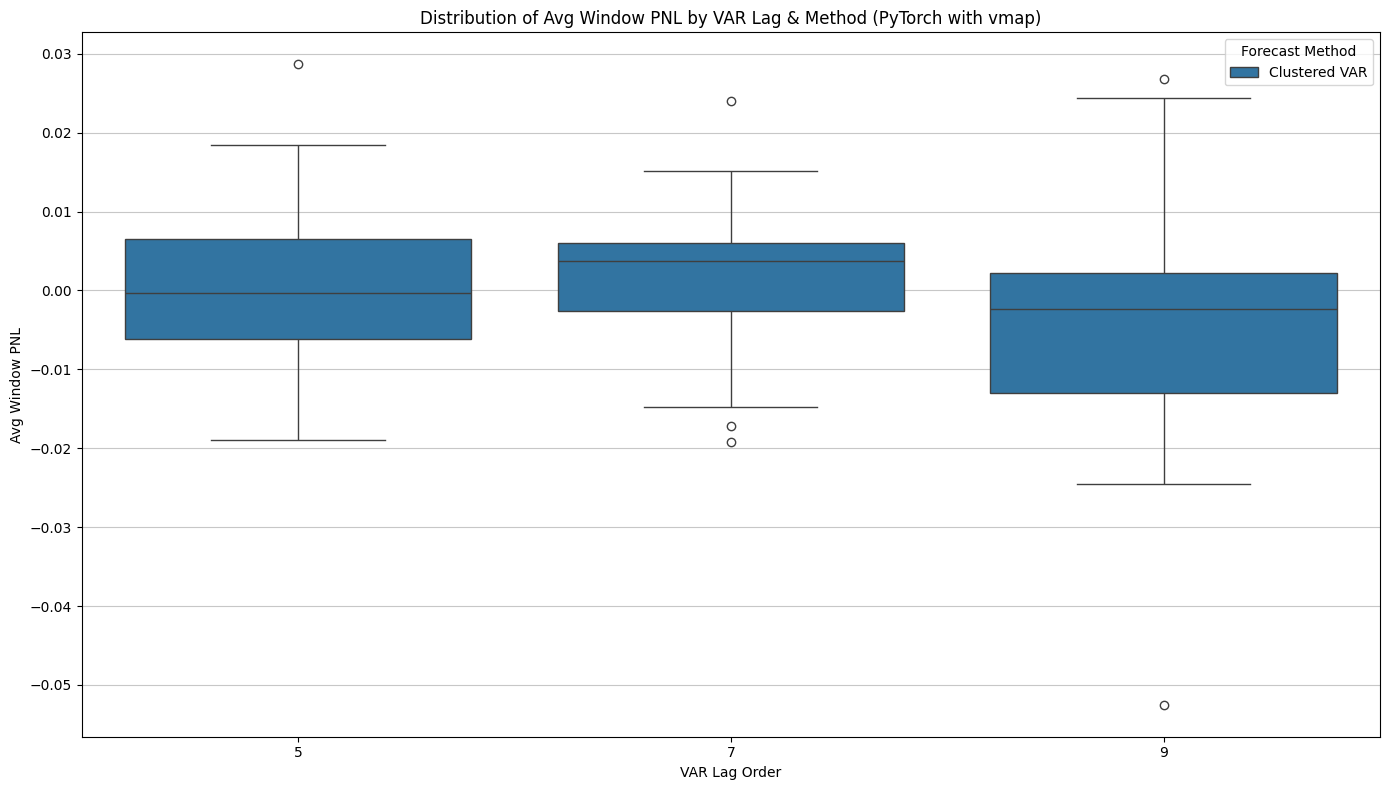


--- Plotting Sample: Window 1, Clustered VAR Lag 9 ---


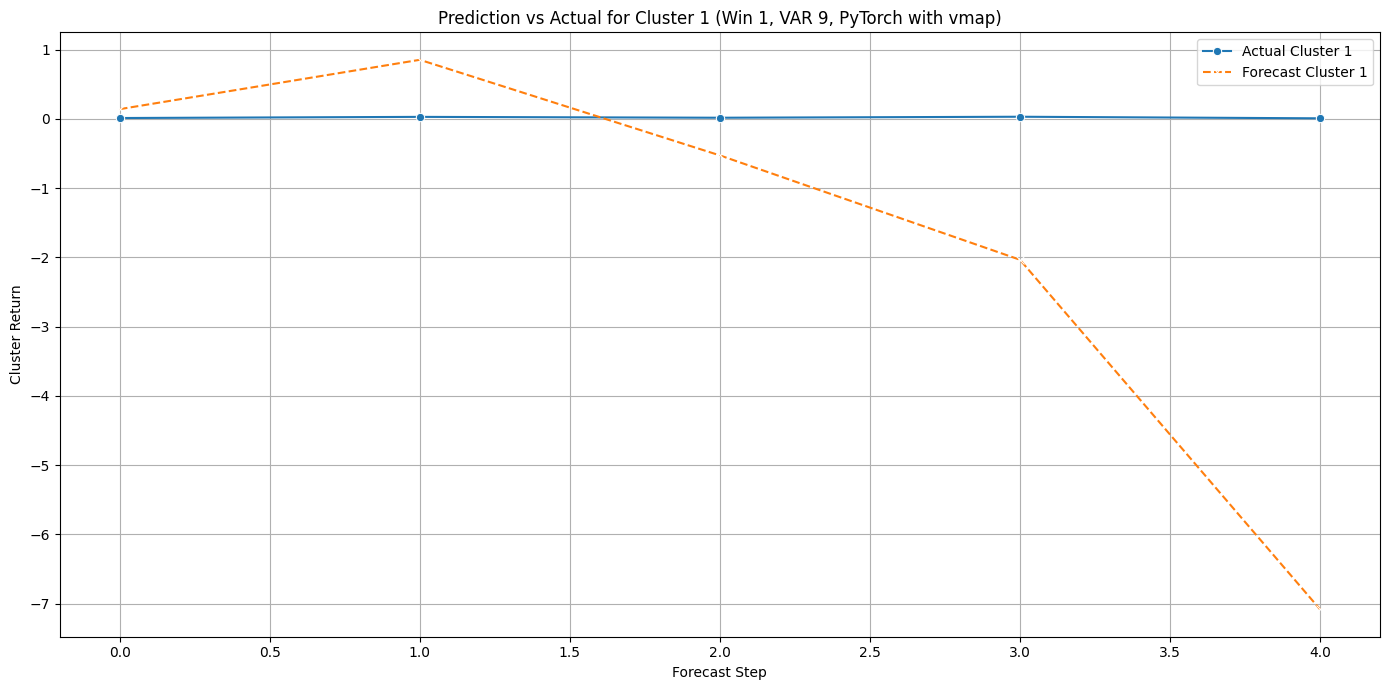

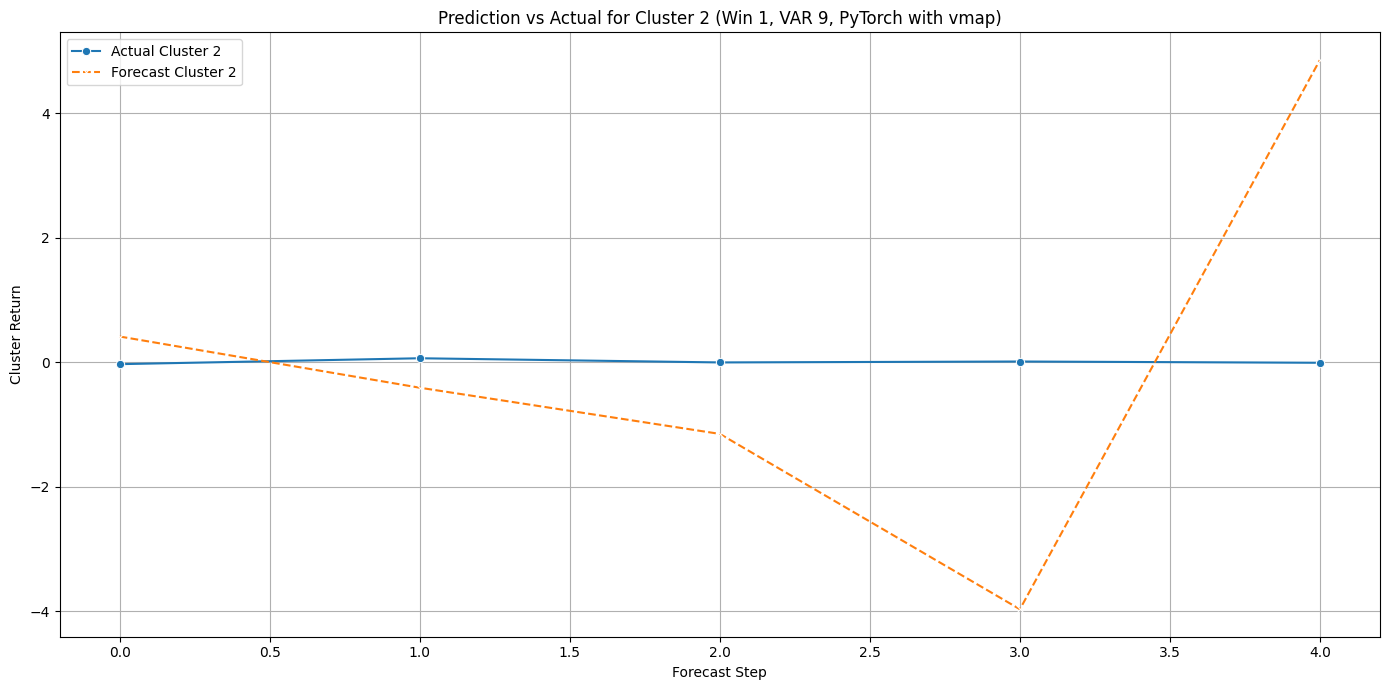

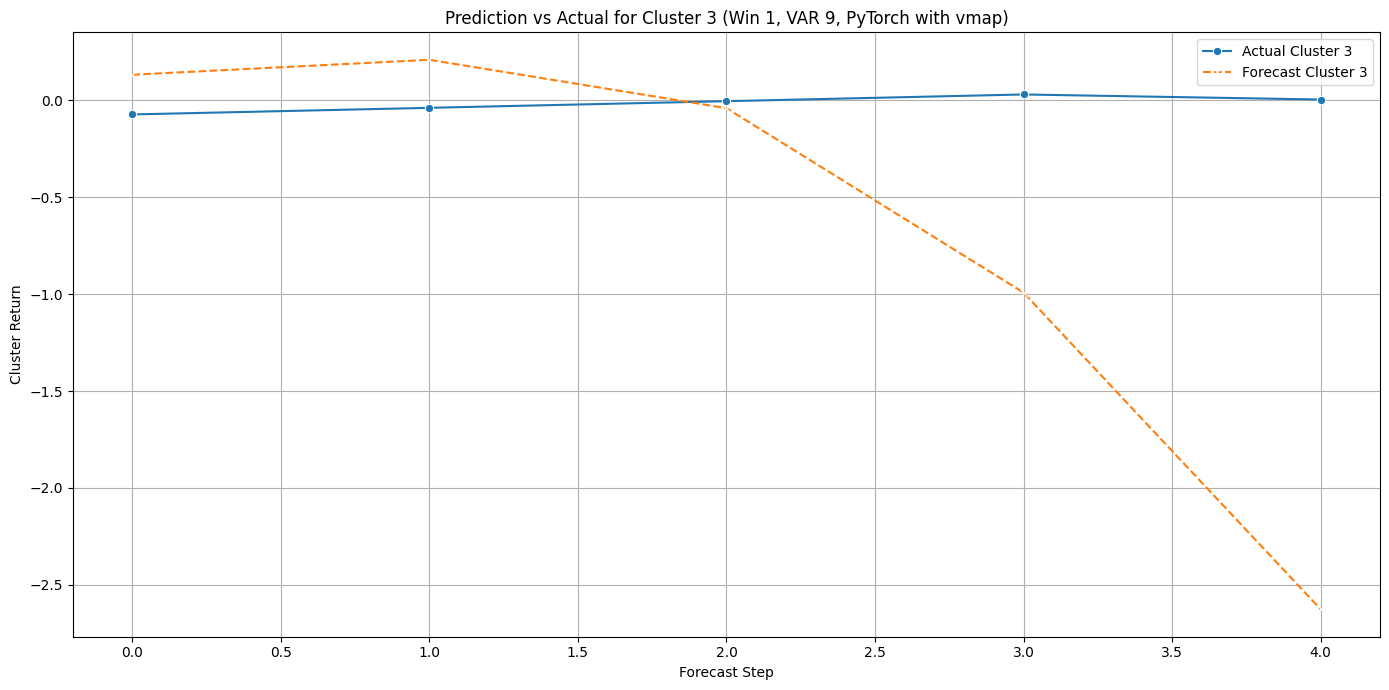

In [10]:
# Removed 'if all_lags_combined_pnl_data:'
agg_data = {}
methods_seen = set()
for record in all_lags_combined_pnl_data: # Will error if all_lags_combined_pnl_data is empty but accessed.
    methods_seen.add(record['Method'])
    key = (record['VAR_Order'], record['Method'])
    agg_data.setdefault(key, []).append(record['Avg_Window_PNL'])

sorted_methods = sorted(list(methods_seen))
# Removed 'if not sorted_methods:'
header = f"{'VAR_Order':<10} | " + " | ".join([f"{m:<15}" for m in sorted_methods])
print("\nAverage Window PNL per Lag Order and Method:")
print(header)
print("-" * len(header))

for var_order in sorted(list(set(r['VAR_Order'] for r in all_lags_combined_pnl_data))):
    row_str = f"{var_order:<10} | "
    for method in sorted_methods:
        pnl_list = agg_data.get((var_order, method), []) # Keep .get for safety or it could KeyError
        # Removed 'if pnl_list:' for calculating avg_pnl. Division by zero if len is 0.
        avg_pnl = sum(pnl_list) / len(pnl_list) if pnl_list else float('nan') # Retained minimal check to avoid div by zero for print
        row_str += f"{avg_pnl:<15.6f} | "
    print(row_str.strip().rsplit('|', 1)[0].strip())


# 3. Visualization
# Removed 'if all_lags_combined_pnl_data:'
# Removed 'try-except' block for plotting
# Filter for valid numeric PNLs for plotting to prevent seaborn/matplotlib errors. This is a practical necessity for plotting.
plot_data_list = [d for d in all_lags_combined_pnl_data if isinstance(d.get('Avg_Window_PNL'), (int, float)) and not np.isnan(d.get('Avg_Window_PNL'))]

# Removed 'if plot_data_list:'
plot_df_data = {
    'VAR_Order': [d['VAR_Order'] for d in plot_data_list],
    'Avg_Window_PNL': [d['Avg_Window_PNL'] for d in plot_data_list],
    'Method': [d['Method'] for d in plot_data_list]
}
plt.figure(figsize=(14, 8))
sns.boxplot(x='VAR_Order', y='Avg_Window_PNL', hue='Method', data=plot_df_data) # Will error if plot_df_data is empty/malformed
plt.title('Distribution of Avg Window PNL by VAR Lag & Method (PyTorch with vmap)')
plt.xlabel('VAR Lag Order'); plt.ylabel('Avg Window PNL')
plt.legend(title='Forecast Method'); plt.grid(True, axis='y', alpha=0.7)
plt.tight_layout(); plt.show()


# Removed 'if final_sample_details and final_sample_details.get('sample_forecast_cluster') is not None:'
# Direct access, will error if keys don't exist or values are None and methods are called.
fc = final_sample_details['sample_forecast_cluster'].cpu().numpy()
ac = final_sample_details['sample_actual_cluster'].cpu().numpy()
win_idx = final_sample_details['sample_window_idx_cluster']
var_ord_sample = final_sample_details['var_order_for_sample']

print(f"\n--- Plotting Sample: Window {win_idx + 1 if win_idx != -1 else 'N/A'}, Clustered VAR Lag {var_ord_sample} ---")
num_series_to_plot = min(3, fc.shape[1]) # fc.shape[1] will error if fc is None
# Removed 'if num_series_to_plot == 0:'

for i in range(num_series_to_plot):
    plt.figure(figsize=(14, 7))
    # Removed data/length validation before plotting. Plotting functions might error.
    sns.lineplot(x=range(len(ac[:, i])), y=ac[:, i], label=f'Actual Cluster {i+1}', marker='o')
    sns.lineplot(x=range(len(fc[:, i])), y=fc[:, i], label=f'Forecast Cluster {i+1}', marker='x', linestyle='--')
    plt.title(f'Prediction vs Actual for Cluster {i+1} (Win {win_idx+1 if win_idx != -1 else "N/A"}, VAR {var_ord_sample}, PyTorch with vmap)')
    plt.xlabel('Forecast Step'); plt.ylabel('Cluster Return')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()